In [90]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division

In [91]:
import warnings
warnings.filterwarnings("ignore")

In [92]:
import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.offline as pyoff


In [93]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [94]:
sales = pd.read_csv('all_sales.csv')
sales.head()
df= sales.drop(columns=['CustomerID','item_price','date_block_num','item_cnt_day','Quantity','shipment','item_category_name','item_category_id'])

In [95]:
#sales.tail()

In [96]:
df['date'] = pd.to_datetime(df['date'])

df.head()


,date,item_id,shop_id,item_name,sales
0,2013-01-01,22154.0,59.0,Scene 2012 (BD),13.0
1,2013-01-02,22154.0,24.0,Scene 2012 (BD),11.0
2,2013-01-03,22154.0,27.0,Scene 2012 (BD),14.0
3,2013-01-04,22154.0,25.0,Scene 2012 (BD),13.0
4,2013-01-05,22154.0,25.0,Scene 2012 (BD),10.0


In [80]:
df.tail(10)

,date,item_id,shop_id,item_name,sales
912990,NaT,NaN,NaN,NaN,NaN
912991,NaT,NaN,NaN,NaN,NaN
912992,NaT,NaN,NaN,NaN,NaN
912993,NaT,NaN,NaN,NaN,NaN
912994,NaT,NaN,NaN,NaN,NaN
912995,NaT,NaN,NaN,NaN,NaN
912996,NaT,NaN,NaN,NaN,NaN
912997,NaT,NaN,NaN,NaN,NaN
912998,NaT,NaN,NaN,NaN,NaN
912999,NaT,NaN,NaN,NaN,NaN


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       500000 non-null  datetime64[ns]
 1   item_id    500000 non-null  float64       
 2   shop_id    500000 non-null  float64       
 3   item_name  500000 non-null  object        
 4   sales      500000 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 34.8+ MB


### Aggregate Data monthly level and sum up sales column

In [82]:
#represent month in date field as its first day
df['date'] = df['date'].dt.year.astype('str') + '-' + df['date'].dt.month.astype('str') + '-01'
#groupby date and sum the sales
df = df.groupby('date').sales.sum().reset_index()

In [83]:
df.head()

,date,sales
0,2013.0-1.0-01,258063.0
1,2013.0-10.0-01,372853.0
2,2013.0-11.0-01,392322.0
3,2013.0-12.0-01,287652.0
4,2013.0-2.0-01,261523.0


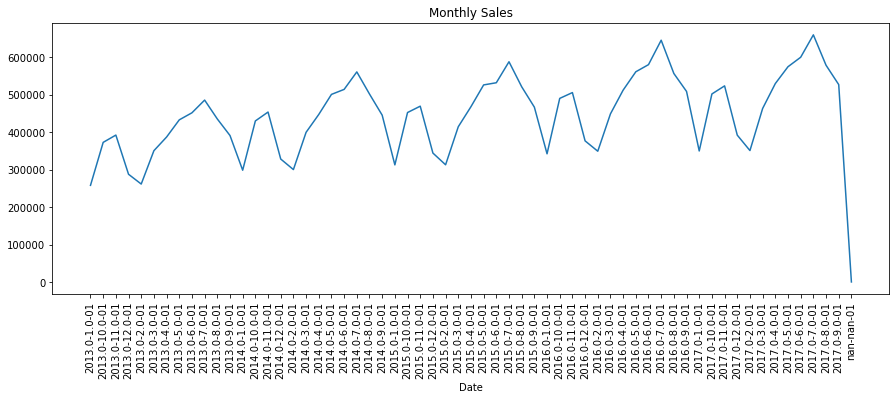

In [84]:
plt.figure(figsize=(15,5))
plt.plot(df['date'],df['sales'])
plt.xticks(rotation=90)
plt.title('Monthly Sales')
plt.xlabel('Date')

plt.show()

### New df to model the differences

In [85]:
#create a new dataframe to model the difference
df_diff = df.copy()
df_diff.head()

,date,sales
0,2013.0-1.0-01,258063.0
1,2013.0-10.0-01,372853.0
2,2013.0-11.0-01,392322.0
3,2013.0-12.0-01,287652.0
4,2013.0-2.0-01,261523.0


In [86]:
#add previous sales to the next row
df_diff['prev_sales'] = df_diff['sales'].shift(1)
df_diff.head()


,date,sales,prev_sales
0,2013.0-1.0-01,258063.0,NaN
1,2013.0-10.0-01,372853.0,258063.0
2,2013.0-11.0-01,392322.0,372853.0
3,2013.0-12.0-01,287652.0,392322.0
4,2013.0-2.0-01,261523.0,287652.0


In [87]:
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['sales'] - df_diff['prev_sales'])
df_diff.head(10)

,date,sales,prev_sales,diff
1,2013.0-10.0-01,372853.0,258063.0,114790.0
2,2013.0-11.0-01,392322.0,372853.0,19469.0
3,2013.0-12.0-01,287652.0,392322.0,-104670.0
4,2013.0-2.0-01,261523.0,287652.0,-26129.0
5,2013.0-3.0-01,350630.0,261523.0,89107.0
6,2013.0-4.0-01,387113.0,350630.0,36483.0
7,2013.0-5.0-01,432998.0,387113.0,45885.0
8,2013.0-6.0-01,451869.0,432998.0,18871.0
9,2013.0-7.0-01,485804.0,451869.0,33935.0
10,2013.0-8.0-01,435385.0,485804.0,-50419.0


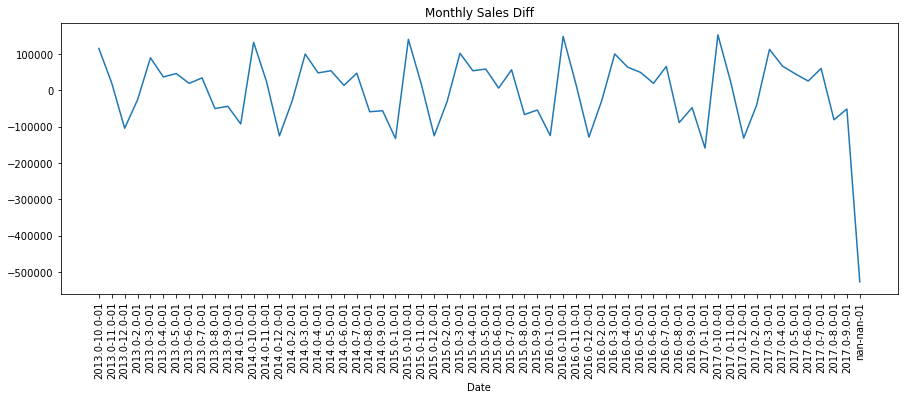

In [89]:
plt.figure(figsize=(15,5))
plt.plot(df_diff['date'],df_diff['diff'])
plt.xticks(rotation=90)
plt.title('Monthly Sales Diff')
plt.xlabel('Date')

plt.show()

### Building feature set

In [65]:
#create new dataframe from transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'],axis=1)

In [66]:
#adding lags
for inc in range(1,17):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)

In [67]:
df_supervised.head(10)


,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16
1,2013-10-01,32611,9873.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-11-01,34828,2217.0,9873.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-12-01,25359,-9469.0,2217.0,9873.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-2-01,22994,-2365.0,-9469.0,2217.0,9873.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2013-3-01,30722,7728.0,-2365.0,-9469.0,2217.0,9873.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2013-4-01,33896,3174.0,7728.0,-2365.0,-9469.0,2217.0,9873.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2013-5-01,38073,4177.0,3174.0,7728.0,-2365.0,-9469.0,2217.0,9873.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2013-6-01,39602,1529.0,4177.0,3174.0,7728.0,-2365.0,-9469.0,2217.0,9873.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2013-7-01,42478,2876.0,1529.0,4177.0,3174.0,7728.0,-2365.0,-9469.0,2217.0,9873.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,2013-8-01,38391,-4087.0,2876.0,1529.0,4177.0,3174.0,7728.0,-2365.0,-9469.0,2217.0,9873.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

### How good are our features?
#### -Fit linear regression & compute Adjusted R-Square

##### Using lag1

In [69]:
# Using only lag1 - to check much it explains the variation in column diff
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

-0.024334386487243176


##### Using lag1-lag5

In [70]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.13610701083363497


##### Using all lags

In [72]:
# Import statsmodels.formula.api
import statsmodels.formula.api as smf 

# Define the regression formula
model = smf.ols(formula='diff ~ lag_1 + lag_2 + lag_3 + lag_4 + lag_5 + lag_6 + lag_7 + lag_8 + lag_9 + lag_10 + lag_11  +lag_12 + lag_13 + lag_14 + lag_15  +lag_16  ', data=df_supervised)

# Fit the regression
model_fit = model.fit()

# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.9865309486917632


### Building model after scaling

#### as test set choosing last 12 months od sales

In [74]:
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['sales','date'],axis=1)
#split train and test set
train_set, test_set = df_model[0:-6].values, df_model[-12:].values

In [75]:
#df_model.info()
len(test_set)

12

#### using minmax scaler for scaling 

In [76]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

#### Building LSTM model

In [77]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

In [78]:
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [79]:
print(test_set)

[[-14245.  -4040.  -7667.   5355.   1663.   4512.   5446.   8730.  -2608.
  -11043.   1260.  12985. -11237.  -4847.  -5244.   4443.    700.]
 [ 13646. -14245.  -4040.  -7667.   5355.   1663.   4512.   5446.   8730.
   -2608. -11043.   1260.  12985. -11237.  -4847.  -5244.   4443.]
 [  1619.  13646. -14245.  -4040.  -7667.   5355.   1663.   4512.   5446.
    8730.  -2608. -11043.   1260.  12985. -11237.  -4847.  -5244.]
 [-11272.   1619.  13646. -14245.  -4040.  -7667.   5355.   1663.   4512.
    5446.   8730.  -2608. -11043.   1260.  12985. -11237.  -4847.]
 [ -3312. -11272.   1619.  13646. -14245.  -4040.  -7667.   5355.   1663.
    4512.   5446.   8730.  -2608. -11043.   1260.  12985. -11237.]
 [  9487.  -3312. -11272.   1619.  13646. -14245.  -4040.  -7667.   5355.
    1663.   4512.   5446.   8730.  -2608. -11043.   1260.  12985.]
 [  6279.   9487.  -3312. -11272.   1619.  13646. -14245.  -4040.  -7667.
    5355.   1663.   4512.   5446.   8730.  -2608. -11043.   1260.]
 [  3989.   6

#### fit the model

In [80]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=1, shuffle=False)

Epoch 1/20
37/37 [==============================] - 0s 2ms/step - loss: 0.2911
Epoch 2/20
37/37 [==============================] - 0s 2ms/step - loss: 0.2740
Epoch 3/20
37/37 [==============================] - 0s 2ms/step - loss: 0.2637
Epoch 4/20
37/37 [==============================] - 0s 2ms/step - loss: 0.2535
Epoch 5/20
37/37 [==============================] - 0s 2ms/step - loss: 0.2430
Epoch 6/20
37/37 [==============================] - 0s 2ms/step - loss: 0.2322
Epoch 7/20
37/37 [==============================] - 0s 2ms/step - loss: 0.2209
Epoch 8/20
37/37 [==============================] - 0s 2ms/step - loss: 0.2091
Epoch 9/20
37/37 [==============================] - 0s 2ms/step - loss: 0.1969
Epoch 10/20
37/37 [==============================] - 0s 2ms/step - loss: 0.1843
Epoch 11/20
37/37 [==============================] - 0s 2ms/step - loss: 0.1716
Epoch 12/20
37/37 [==============================] - 0s 2ms/step - loss: 0.1588
Epoch 13/20
37/37 [==============================

In [81]:
y_pred = model.predict(X_test,batch_size=1)


In [82]:
y_pred

array([[ 0.07066404],
       [ 0.44632682],
       [ 0.28647676],
       [-0.264167  ],
       [-0.1883947 ],
       [ 0.626336  ],
       [ 0.4341678 ],
       [ 0.26239488],
       [ 0.11132587],
       [ 0.38715795],
       [-0.06259281],
       [-0.41793823]], dtype=float32)

In [83]:
y_test

array([[-1.        ],
       [ 1.        ],
       [ 0.13757126],
       [-0.78681295],
       [-0.2160195 ],
       [ 0.7017676 ],
       [ 0.47172923],
       [ 0.30751855],
       [ 0.19113693],
       [ 0.39837223],
       [-0.52300025],
       [-0.28428525]])

In [84]:
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])

In [85]:
print(len(y_pred))

12


In [86]:
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print (np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))

[[ 0.07066404 -0.26822272 -0.52830662  0.4054713   0.1407264   0.37767169
   0.38141538  0.65087179 -0.27942564 -0.97152821  0.03794872  1.
  -0.98744615 -0.46313846 -0.49571282  0.29911795 -0.008     ]]
[[ 0.44632682 -1.         -0.26822272 -0.52830662  0.4054713   0.16841719
   0.30477949  0.38141538  0.65087179 -0.27942564 -0.97152821  0.03794872
   1.         -0.98744615 -0.46313846 -0.49571282  0.29911795]]
[[ 0.28647676  1.         -1.         -0.26822272 -0.52830662  0.43958869
   0.07101538  0.30477949  0.38141538  0.65087179 -0.27942564 -0.97152821
   0.03794872  1.         -0.98744615 -0.46313846 -0.49571282]]
[[-0.26416701  0.13757126  1.         -1.         -0.26822272 -0.51685641
   0.37394872  0.07101538  0.30477949  0.38141538  0.65087179 -0.27942564
  -0.97152821  0.03794872  1.         -0.98744615 -0.46313846]]
[[-0.1883947  -0.78681295  0.13757126  1.         -1.         -0.25045905
  -0.69452308  0.37394872  0.07101538  0.30477949  0.38141538  0.65087179
  -0.2794256

In [87]:
pred_test_set[0]


array([[ 0.07066404, -0.26822272, -0.52830662,  0.4054713 ,  0.1407264 ,
         0.37767169,  0.38141538,  0.65087179, -0.27942564, -0.97152821,
         0.03794872,  1.        , -0.98744615, -0.46313846, -0.49571282,
         0.29911795, -0.008     ]])

In [88]:
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [89]:
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [90]:
print(len(pred_test_set_inverted))

12


#### Calculating predicted sales number 

In [91]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df[-13:].date)
#print(sales_dates)
#print(len(sales_dates))
act_sales = list(df[-13:].sales)
#print(act_sales)


In [92]:
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    #print(index+1)
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)

In [113]:
df_result

,pred_value,date
0,45372,2017-1-01
1,36366,2017-10-01
2,47783,2017-11-01
3,41723,2017-12-01
4,31508,2017-2-01
5,39558,2017-3-01
6,46365,2017-4-01
7,50248,2017-5-01
8,52130,2017-6-01
9,58343,2017-7-01


In [114]:
df.head()

,date,sales
0,2013-1-01,22738
1,2013-10-01,32611
2,2013-11-01,34828
3,2013-12-01,25359
4,2013-2-01,22994


### Merging predicted sales with actual sales

In [115]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(df,df_result,on='date',how='left')
df_sales_pred


,date,sales,pred_value
0,2013-1-01,22738,NaN
1,2013-10-01,32611,NaN
2,2013-11-01,34828,NaN
3,2013-12-01,25359,NaN
4,2013-2-01,22994,NaN
5,2013-3-01,30722,NaN
6,2013-4-01,33896,NaN
7,2013-5-01,38073,NaN
8,2013-6-01,39602,NaN
9,2013-7-01,42478,NaN


In [116]:
df_sales_pred.tail(10)

,date,sales,pred_value
50,2017-11-01,45707,47783.0
51,2017-12-01,34435,41723.0
52,2017-2-01,31123,31508.0
53,2017-3-01,40610,39558.0
54,2017-4-01,46889,46365.0
55,2017-5-01,50878,50248.0
56,2017-6-01,53244,52130.0
57,2017-7-01,58500,58343.0
58,2017-8-01,50907,57327.0
59,2017-9-01,46643,44779.0


### Prediction plotting

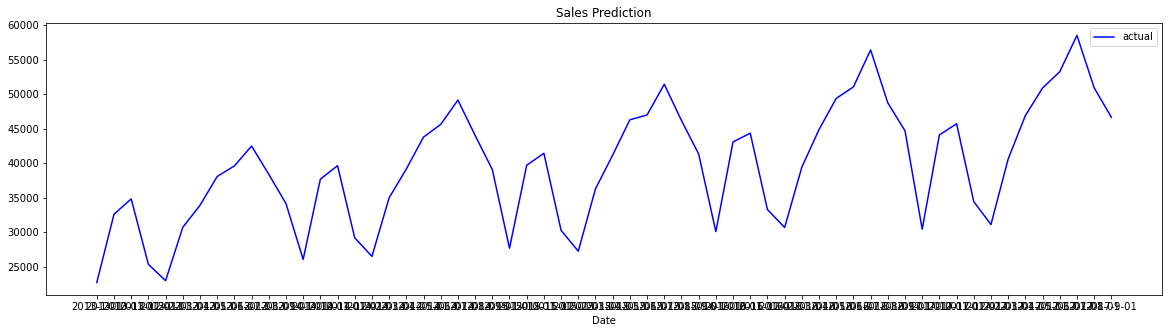

In [117]:

plt.figure(figsize=(20,5))
plt.plot(df_sales_pred['date'],df_sales_pred['sales'],'b',label='actual')

plt.title('Sales Prediction')
plt.xlabel('Date')

plt.legend()


plt.show()

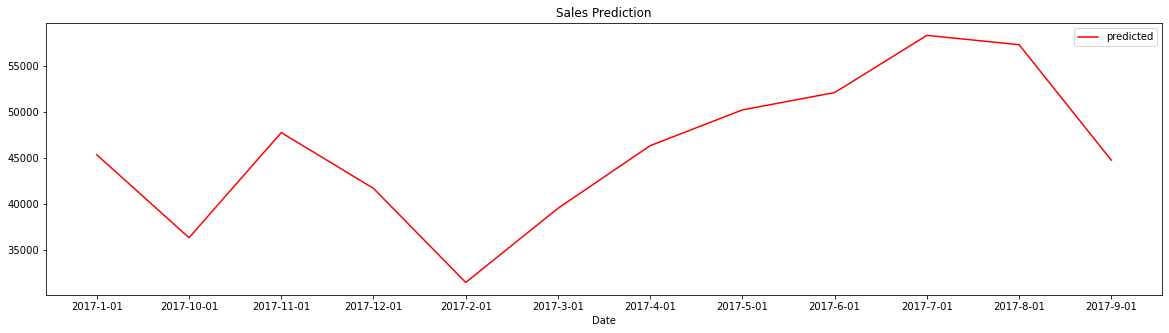

In [118]:
plt.figure(figsize=(20,5))
plt.plot(df_sales_pred['date'],df_sales_pred['pred_value'],'r',label='predicted')

plt.title('Sales Prediction')
plt.xlabel('Date')
#plt.xticks(df_sales_pred['date']))
plt.legend()
plt.show()